In [19]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'width': 1000,
              'height': 600,
              'scroll': True,
})

{'width': 1000, 'height': 600, 'scroll': True}

# Dotua 
## An Automatic Differentiation Python Package
### Nick Stern, Summer Yuan, Zach Wehrwein, Vincent Viego

## Structure of Presentation
1. Relevance of automatic differentiation
2. Forward mode high level/deep dive
3. Reverse mode background/importance
4. Reverse mode high level/deep dive
5. Newton Raphson + Neural Network Demos

## Automatic Differentiation - Why Does it Matter?

* ### What is automatic differentiation?
  * A way to take derivatives quickly with machine precision

* ### How does it work?
  * Propagate derivatives of elementary functions as more complicated ones are built
  <img src="images/autodiff_graph.png" width="600" align="center">

* ### Why do we care?
  * Derivatives are everywhere!!
  * Tons of numerical simulations involving diffeq’s, i.e. hydrodynamics simulations
    * Nuclear Fusion, Oceanography, Modeling Gravity
  * Applications in optimization
    * Neural Networks
    * Robotics

### Lawrence Livermore National Lab Kinematic Impact Studies:
<img src="images/spheral_image.png" width="800" align="center">

## Forward Mode at a Glance
### Initializer class: AutoDiff  
* Two object classes:
  * Scalar:
    * Stores value in ._val
    * Stores jacobian in dictionary
    * Allows for “f = x + y”
  * Vector:
    * Permits elementwise operations
    * Stores value in ._val
    * Stores jacobian in dictionary
       * Jacobian refers to elements in vector
       
### Operator class: Operator
* Exactly like numpy but for AutoDiff objects.


### How to Use Forward Mode

In [ ]:
from Dotua.autodiff import AutoDiff as ad
from Dotua.operator import Operator as op

In [ ]:
x, y = ad.create_scalar([1,2])
f = x - y
f.eval()

## Forward Mode deep dive

### What if users add more variables after some functions are defined?

* Imagine we construct a function f = x + y from variables x and y

* We use [1,0] for the initial derivative of x  and [0,1] for the initial derivative of y

* Everything is fine as long as user only defines functions of x and y

* Then the user defines two new variables a and b and builds a new function g = a + b

* We use [1,0] for the initial derivative of a  and [0,1] for the initial derivative of b

* Then the user defines a new function h = f + g

* And when the user calls partial for the gradient of function h with regarding to a, they get 2

* ### They adds up variables in different universes

### Two undesirable solutions
* Prevent the user from combining functions with separately initialized sets of variables
* Put all the variables in a container datastructure and require the user to remember the order in which the variables were initialized

### Our solution
* Use dictionaries to keep track of gradients of every variable included in the functions. Variable objects are used as keys of the dictionaries

## Forward Mode Demo: Newton-Raphson Root Approximation

### Some imports...

In [ ]:
import sys
from Dotua.autodiff import AutoDiff as ad
from Dotua.operator import Operator as op
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

### The Algorithm:

In [5]:
def NewtonsMethod(func, x0, tol=1e-15, maxiters=1000):
    '''
    Computes the roots of func through iterative guesses until change is below tolerance.

    Takes in a function (func), a point at which to estimate (x0),
        an error tolerance (tol), and a maximum number of iterations (maxiters).

    func must be composed of 'AutoDiff.Operator' operations and AutoDiff.Scalar structures.

    Example usage:
    '''

    xn = x0
    steps = []

    for i in range(maxiters):

        # Calculate y at this step.
        y = func(xn)._val

        # Calculate derivative at this step
        dy_dx = list(func(xn)._jacobian.values())[0]

        # If y reaches tolerance, stop
        if abs(y) < tol:
            return xn._val, steps
            break

        else:
            steps.append((xn._val, y))
            # Compute Newton Step
            x_next = y / dy_dx

            # Update X
            xn = xn - x_next


    return xn._val, steps

### Comparison

In [22]:
ans, steps = NewtonsMethod(lambda x: x*x, ad.create_scalar(1))
print('Root Found Using Dotua: ', ans)
print('Root Found Using Standard Library: ', optimize.newton(lambda x: x**2, 1))

Root Found Using Dotua:  2.9802322387695312e-08
Root Found Using Standard Library:  1.5813234334835293e-08


### Let's Visualize It!

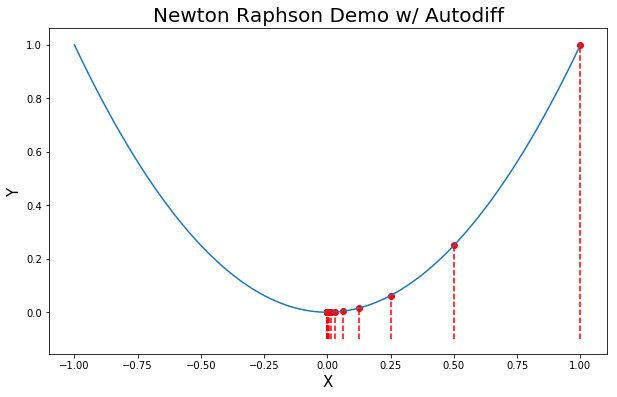

In [9]:
xvals = np.linspace(-1,1,100)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter([x[0] for x in steps], [x[1] for x in steps], c='r')
ax.plot(xvals, xvals**2)
for step in steps:
    ax.plot([step[0]]*100, np.linspace(-.1, step[1],100), 'r--')
    ax.set_xlabel('X', fontsize=15)
    ax.set_ylabel('Y', fontsize=15)
    ax.set_title('Newton Raphson Demo w/ Autodiff', fontsize=20)
    
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_title('Newton Raphson Demo w/ Autodiff', fontsize=20)

plt.savefig('newton.png')
plt.show()

# Reverse Mode Motivation

- Forward mode allows efficient computation of the partial derivatives of multiple functions.
- Reverse mode allows efficient computation of the gradient of a single function.
- In NN: we wish to calculate the slope of each weight w/r/t a loss function.
- AD a necessary aspect of contemporary ML because it allows for us to make this calculation.

For a given input $u$, output $w_1$, and a yet-to-be calculated variable $s$:

Forward mode chain rule:

$$\frac{\partial w}{\partial t} = \frac{\partial w}{\partial u_1} * \frac{\partial u_1}{\partial t} + \frac{\partial w}{\partial u_2} * \frac{\partial u_2}{\partial t} + ...  $$

Backward chain rule (inversion of composite functions by flipping numerator and denominator):

$$\frac{\partial s}{\partial u} = \frac{\partial w_1}{\partial u} * \frac{\partial s}{\partial w_1} + \frac{\partial w_2}{\partial u} * \frac{\partial s}{\partial w_2} + ... $$


- Graph theory intuition most useful.

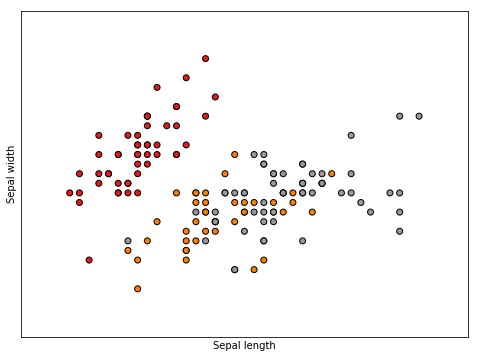

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data 
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

In [13]:
from Dotua.rautodiff import rAutoDiff as rad
from Dotua.roperator import rOperator as op
import random

rad = rad()

class NeuralNetwork():
    def __init__(self, input_vals, input_bias, hidden_bias, num_hidden, output, learning_rate = 0.1):
        self.input_vals = input_vals
        self.input_bias = input_bias
        self.hidden_bias = hidden_bias
        self.num_hidden = num_hidden
        self.output = output
        self.learning_rate = learning_rate

        self.weights_tohidden = [None] * num_hidden
        for i in range(num_hidden):
            self.weights_tohidden[i] = []
            for j in range(len(input_vals)):
                
                #DOTUA USED HERE: to initalize the weights from the input to hidden layer.
                w = rad.create_rscalar(random.random())
                self.weights_tohidden[i].append(w)
                self.weights_tooutput = [None] * len(output)
        
        for i in range(len(output)):
            self.weights_tooutput[i] = []
            
            #DOTUA USED HERE: to initialize weights from hidden to output.
            w = rad.create_rscalar(random.random())
            for j in range(num_hidden):
                self.weights_tooutput[i].append(w)

    def train(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        #calculation of hidden layer.
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons and error
        error = 0
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            error = error + (o - self.output[i]) ** 2

        # To update weights from hidden layer to output layer
        for i in range(len(self.weights_tooutput)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tooutput[i][j])
                self.weights_tooutput[i][j] = self.weights_tooutput[i][j] - d * self.learning_rate

        # To update weights from input layer to hidden layer
        for i in range(len(self.weights_tohidden)):
            for j in range(len(self.weights_tooutput[i])):
                
                #DOTUA USED HERE:
                d = rad.partial(error, self.weights_tohidden[i][j])
                self.weights_tohidden[i][j] = self.weights_tohidden[i][j] - d * self.learning_rate

    def predict(self, input_vals, output_vals):
        self.input_vals = input_vals
        self.output = output_vals

        # To calculate the hidden layer neurons using the current model
        self.hidden_layer = []
        for i in range(self.num_hidden):
            h = 0
            for j in range(len(self.weights_tohidden[i])):
                h = h + self.weights_tohidden[i][j] * self.input_vals[j]
            h = h + self.input_bias
            self.hidden_layer.append(1/(1+op.exp(-h)))

        # To calculate the output layer neurons using the current model and calculate the error 
        error = 0
        output_layer = []
        for i in range(len(self.output)):
            o = 0
            for j in range(len(self.weights_tooutput[i])):
                o = o + self.weights_tooutput[i][j] * self.hidden_layer[j]
            o = o + self.hidden_bias
            o = 1/(1+op.exp(-o))
            output_layer.append(o.val)
            error = error + (o - self.output[i]) ** 2
        error = error / len(self.output)
        return (output_layer, error.val)

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=64)

def get_y(i):
    train_y = [0,0,0]
    train_y[i] = 1
    return train_y

nn = NeuralNetwork([0,0,0],0.33,0.33,2,[0,0,0])

for j in range(10):
    for i in range(1, len(X_train)):
        nn.train(X_train[i], get_y(y_train[i]))

train_e = []
true_y = []
predicted_y = []
for i in range(1, len(X_train)):
    output,e = nn.predict(X_train[i], get_y(y_train[i]))
    train_e.append(e)
    if max(output) == output[0]:
        predicted_y.append(0)
    elif max(output) == output[1]:
        predicted_y.append(1)
    else:
        predicted_y.append(2)
    
    true_y.append(y_train[i])

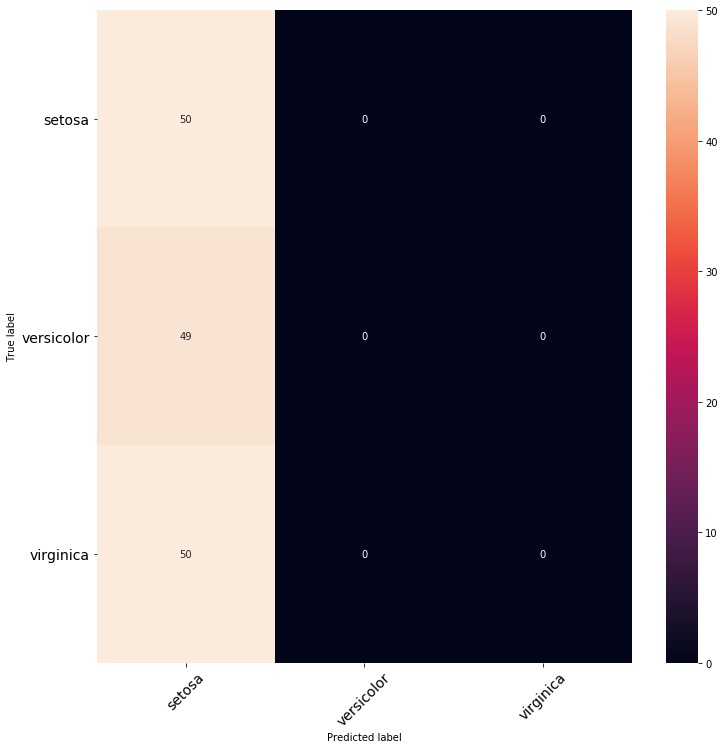

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

df_cm = pd.DataFrame(confusion_matrix(true_y,predicted_y),
                     index=['setosa','versicolor','virginica'], columns=['setosa','versicolor','virginica'])
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### How to Use Reverse Mode

In [ ]:
from Dotua.rautodiff import rAutoDiff
from Dotua.roperator import rOperator as rop

In [ ]:
rad = rAutoDiff()
w, z = rad.create_rscalar([2,3])

In [ ]:
f2 = 2*w - 4*z
print(f2.eval())
print(rad.partial(f2, w))

# Reverse Mode Implementation (High Level)

#### In designing our implementation we have focused on 

1. Expressibility
2. Efficiency
3. Ease of Use

## Expressibility

Given that Dotua is meant as a partial NumPy replacement, it is essential that users are able to express any mathematical function with Dotua that they could with NumPy.  To this end Dotua offers the following function support with reverse mode automatic differentation

- Basic functions: addition, subtraction, multiplication, division, exponentiation, and negation
- Trigonometric functions: sine, cosine, and tangent
- Inverse trigonometric functions: arcsine, arccosine, arctangent, 
- Hyperbolic functions: 
- Logarithms of any base
- Roots of arbitrary degree
- Logistic functions

In [3]:
# Complex function demo
rad_init = rAutoDiff()

vals = [7, 11, 13, 17, 23, 29]
a, b, c, d, f, h = rad.create_rscalar(vals)

func = op.arccosh(a) / (op.log(c) ** (op.arcsin(b ** -2))) + \
       op.cos((op.tan(h + a) ** op.log(d * h, base=2)) / (op.sin(f) * op.cos(f))

func.eval()
func.partial(a)
func.partial(b)
func.partial(c)
func.partial(d)
func.partial(f)
func.partial(h)

Note: Embed Wolfram Alpha calculation of derivative

## Eficiency

- Compared with forward mode, fewer operations necessary to compute a gradient of a single function
- O(n) vs. O(m)

## Ease of Use

- Similar to NumPy definitions
- Extensive function support

# Reverse Mode Implementation (Low Level)

#### In designing our implementation we have focused on 

1. rScalar
2. rOperator
3. rAutoDiff

## rScalar



## rOperator



## rAutoDiff

